In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn import preprocessing
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import os

In [49]:
def sliding_window(x, w = 1, d = 0):
    # This function creates a data array formatted in sliding windows.
    # Parameters: X, the input data, which must be a time series in an array of a singel dimension
    #             w, the width of the window
    #             d, the number of elements of the previous window present in the next one.
    #             For the present homework, we use a window shift of 1 position, so then d = w-1
    #             X is the output, and it is an array with the formatted data.
    N = len(x)
    x=x.reshape(x.size,)
    m = int(np.ceil((N-w)/(w-d)))
    X = np.zeros([w,m])
    for i,j in zip(range(0,N,w-d),range(0,m)):
        X[:,j] = x[i:i + w]
    return X

def plot_graphs(y_tst, y_tst_raw, mean_raw, std_raw, M, L, title):
  # This plots the results of the GP prediction, so you do not spend time figuring this out.
  # Parameters: y_tst is the time series of true regressors
  #             mean is the mean value of the prediction
  #             std is the standard deviation of the prediction
  #             tittle is a string with the title that you want to show in the graphic.
  plt.plot(y_tst_raw[:L,], label="Observations",color="black")
  plt.plot(mean_raw, label="Mean prediction",color="red")
  plt.fill_between(
    np.arange(y_tst[:L,].size).ravel(),
    mean_raw - 1.96 * std_raw,
    mean_raw + 1.96 * std_raw,
    alpha=0.5,
    label=r"95% confidence interval",
  )
  plt.legend()
  plt.xlabel("$time$ (hours)")
  plt.ylabel("$Load$ (MW)")
  plt.title(title)
  # Save plots to folder
  dir_name = os.getcwd()
  folder_name = "hw8_pics"
  folder_directory = os.path.join(dir_name, folder_name)
  file_name = f"{L}_interval_{M}_prediction.png"
  full_name = os.path.join(folder_directory, file_name)
  plt.savefig(full_name)
  plt.show()
  

def scale_data(training_data, test_data=None):
    # Returns a scaled COPY of the data.  Reshapes the data to an (N, 1) array
    # Parameter: data, the data you wish to normalize
    #            test_data, OPTIONAL test data you wish to normalize according
    #                       to the training data.  Defaults to None.
    # Outputs:   output, scaled training data
    #            scaler_data, the function with the scaling parameters
    #            test_out, OPTIONAL scaled test data
    # REQUIRES: sklearn.preprocessing imported.

    temp = training_data.copy()
    temp = temp.reshape(temp.size, 1)
    scaler_data = preprocessing.StandardScaler().fit(temp)
    output = scaler_data.transform(temp)
    if test_data is not None:
        temp2 = test_data.copy()
        temp2 = temp2.reshape(temp2.size, 1)
        test_out = scaler_data.transform(temp2)
        return output, scaler_data, test_out
    return output, scaler_data


In [50]:
train_datafile = "2020_CT.txt"
x_train_raw=np.loadtxt(train_datafile, dtype=float)
# x_train_raw=x_train_raw.reshape(x_train_raw.size,1) # Here we need to convert it to an array with (N,1) dimensions for the normalization function to accept it.

test_datafile = "2021_CT.txt"
x_test_raw=np.loadtxt(test_datafile, dtype = float)             # Here we load the test data
# x_test_raw=x_test_raw.reshape(x_test_raw.size,1) 

x_train, scaler, x_test = scale_data(x_train_raw, x_test_raw)


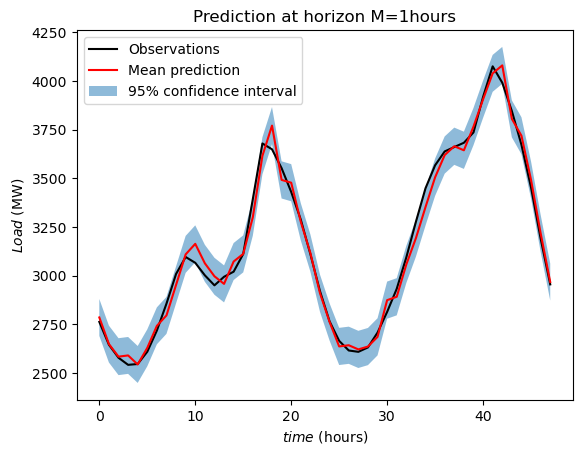

In [51]:

# Data formatting and training
W = 24  # Window length
M = 1   # Prediction horizon of M hours
L = 24*2 # Predictions interval
            # so in this case, we are predicting the next hour after our training sample,
            # and we are doing it for the next 48 hours (2 days)

#a) Train a GP using a linear and another one using square exponential kernel for T=1000  (1000 training samples) and M=1 (horizon equal to one hour).
X_train1=sliding_window(x_train[:-M],W,W-1).T # W is the window length and W-S is such that S is the sliding intervals
                                                # i.e. number of training windows
                                                # The extra -1 is to account for 0 index.
y_train1=x_train[M+W-1:]

#b) Test it with the first week of January, 2021 and plot the mean and confidence intervals of any day of that week. 
#c) Test it with the first week of July, 2021 (which starts in day 182) and plot the mean and confidence interval. 
X_test1=sliding_window(x_test[:-M],W,W-1).T
y_test1=x_test[M+W-1:]

kernel = DotProduct(0.1) + WhiteKernel(0.1)


gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer = 9)
gp.fit(X_train1[:1000,:], y_train1[:1000,:])  # Transpose X_train
mean_prediction1, std_deviation1 = gp.predict(X_test1[:L,:], return_std=True)  # Predict on the training set for demonstration

mean_raw = scaler.inverse_transform(mean_prediction1.reshape(mean_prediction1.size,1)).reshape(mean_prediction1.size,)
std_raw = std_deviation1*np.sqrt(scaler.var_)
y_test_raw = scaler.inverse_transform(y_test1)
plot_graphs(y_test1, y_test_raw, mean_raw, std_raw, M, L, "Prediction at horizon M=" +str(M)+"hours")


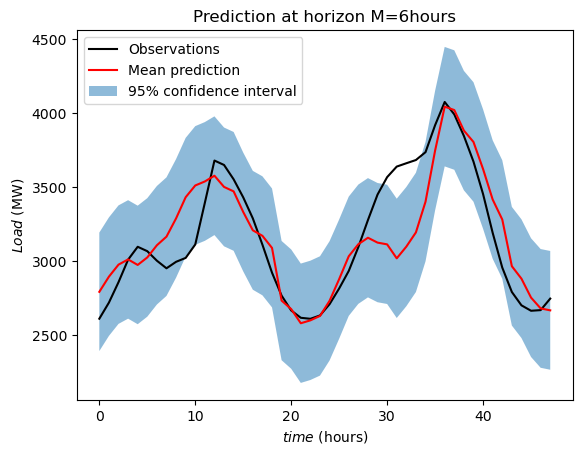

In [52]:

# Data formatting and training
W = 24  # Window length
M = 6   # Prediction horizon of M hours
L = 24*2 # Predictions interval

X_train2=sliding_window(x_train[:-M],W,W-1).T # W is the window length and W-S is such that S is the sliding intervals
y_train2=x_train[M+W-1:]

X_test2=sliding_window(x_test[:-M],W,W-1).T
y_test2=x_test[M+W-1:]

kernel = DotProduct(0.1) + WhiteKernel(0.1)


gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer = 9)
gp.fit(X_train2[:1000,:], y_train2[:1000,:])  # Transpose X_train
mean_prediction2, std_deviation2 = gp.predict(X_test2[:L,:], return_std=True)  # Predict on the training set for demonstration

mean_raw = scaler.inverse_transform(mean_prediction2.reshape(mean_prediction2.size,1)).reshape(mean_prediction2.size,)
std_raw = std_deviation2*np.sqrt(scaler.var_)
y_test_raw = scaler.inverse_transform(y_test2)
plot_graphs(y_test2, y_test_raw, mean_raw, std_raw, M, L, "Prediction at horizon M=" +str(M)+"hours")


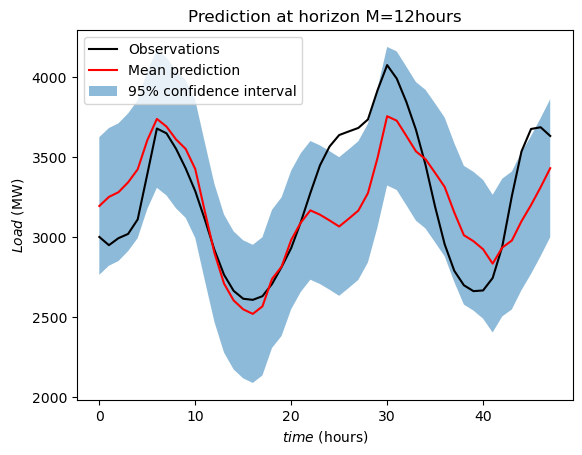

In [55]:

# Data formatting and training
W = 24  # Window length
M = 12   # Prediction horizon of M hours
L = 24*2 # Predictions interval

X_train3=sliding_window(x_train[:-M],W,W-1).T # W is the window length and W-S is such that S is the sliding intervals
y_train3=x_train[M+W-1:]

X_test3=sliding_window(x_test[:-M],W,W-1).T
y_test3=x_test[M+W-1:]

kernel = DotProduct(0.1) + WhiteKernel(0.1)


gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer = 9)
gp.fit(X_train3[:1000,:], y_train3[:1000,:])  # Transpose X_train
mean_prediction3, std_deviation3 = gp.predict(X_test3[:L,:], return_std=True)  # Predict on the training set for demonstration

mean_raw = scaler.inverse_transform(mean_prediction3.reshape(mean_prediction3.size,1)).reshape(mean_prediction3.size,)
std_raw = std_deviation3*np.sqrt(scaler.var_)
y_test_raw = scaler.inverse_transform(y_test3)
plot_graphs(y_test3, y_test_raw, mean_raw, std_raw, M, L, "Prediction at horizon M=" +str(M)+"hours")

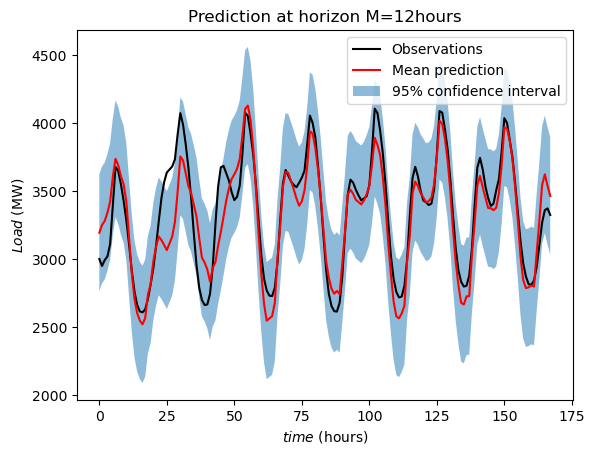

In [54]:

# Data formatting and training
W = 24  # Window length
M = 12   # Prediction horizon of M hours
L = 24*7 # Predictions interval

X_train4=sliding_window(x_train[:-M],W,W-1).T # W is the window length and W-S is such that S is the sliding intervals
y_train4=x_train[M+W-1:]

X_test4=sliding_window(x_test[:-M],W,W-1).T
y_test4=x_test[M+W-1:]

kernel = DotProduct(0.1) + WhiteKernel(0.1)


gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer = 9)
gp.fit(X_train4[:1000,:], y_train4[:1000,:])  # Transpose X_train
mean_prediction4, std_deviation4 = gp.predict(X_test3[:L,:], return_std=True)  # Predict on the training set for demonstration

mean_raw = scaler.inverse_transform(mean_prediction4.reshape(mean_prediction4.size,1)).reshape(mean_prediction4.size,)
std_raw = std_deviation4*np.sqrt(scaler.var_)
y_test_raw = scaler.inverse_transform(y_test4)
plot_graphs(y_test4, y_test_raw, mean_raw, std_raw, M, L, "Prediction at horizon M=" +str(M)+"hours")